In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

S = 1024
MAX_ITER = 1000
SAMPLES = 8

T1 = MAX_ITER // 50
T2 = MAX_ITER // 10
T3 = MAX_ITER

def buddhabrot():
    prev_frame = tf.input([S, S, 3], tf.float32)
    frame_id = tf.input([1], tf.int32)
    time_var = tf.input([1], tf.float32)[0]

    atomic_canvas = tf.zeros([S, S, 3], tf.int32)
    i, j = tf.indices([S, S])
    x, y = tf.float(i), tf.float(j)
    seed = tf.uint(i + j * S + frame_id[0] * S * S)
    aspect = tf.float(S) / tf.float(S)

    with tf.loop(SAMPLES):
        seed.set(tf.pcg(seed))
        u = (x + 2.0*tf.pcgf(seed)) / tf.float(S)
        v = (y + 2.0*tf.pcgf(seed + tf.uint(5))) / tf.float(S)
        u0 = (x + 2.0*tf.pcgf(seed + tf.uint(25))) / tf.float(S)
        v0 = (y + 2.0*tf.pcgf(seed + tf.uint(388))) / tf.float(S)

        cx = (u * 2.0 - 1.0) * aspect * 1.5
        cy = (v * 2.0 - 1.0) * aspect * 1.5
        z0x = (u0 * 2.0 - 1.0) * aspect * 1.5
        z0y = (v0 * 2.0 - 1.0) * aspect * 1.5

        z_re = tf.copy(z0x)
        z_im = tf.copy(z0y)
        l = tf.zeros([], tf.int32)
        c_re = cx
        c_im = cy

        def mandelbrot_iter(z_re, z_im):
            z_re_new = z_re*z_re - z_im*z_im + c_re
            z_im_new = 2.0*z_re*z_im + c_im
            z_re.val = z_re_new
            z_im.val = z_im_new
            with tf.if_cond((z_re*z_re + z_im*z_im) > 4.0):
                tf.break_loop()

        with tf.loop(MAX_ITER):
            mandelbrot_iter(z_re, z_im)
            l.val += 1

        with tf.if_cond(l >= MAX_ITER):
            tf.continue_loop()

        z_re.val = z0x
        z_im.val = z0y

        with tf.loop(MAX_ITER):
            mandelbrot_iter(z_re, z_im)
            
            px = (tf.cos(.3*time_var) * z_re + tf.sin(.3*time_var) * c_re) / 1.5 / aspect * 0.5 + 0.6
            py = (tf.cos(.3*time_var) * z_im + tf.sin(.3*time_var) * c_im) / 1.5 / aspect * 0.5 + 0.5
            with tf.if_cond((px < 0.0) | (px > 1.0) | (py < 0.0) | (py > 1.0)):
                tf.continue_loop()
            x_pix = tf.int(px * tf.float(S))
            y_pix = tf.int(py * tf.float(S))
            
            ch = tf.select(l < T1, 2, tf.select(l < T2, 1, 0))
            tf.scatterAdd(atomic_canvas[S - 1 - y_pix, x_pix, ch], 1)
            tf.scatterAdd(atomic_canvas[y_pix, x_pix, ch], 1)

    canvas = tf.buffer([S, S, 3], tf.float32)

    x = tf.float(atomic_canvas[i, j, 0])
    y = tf.float(atomic_canvas[i, j, 1])
    z = tf.float(atomic_canvas[i, j, 2])
    rx = x + y + z
    ry = y + z
    rz = z

    norm = float(MAX_ITER * SAMPLES) / 12.0

    fid =  tf.float(frame_id[0])
    canvas[i, j, 0] = (tf.smoothstep(0.0, 1.0, 2.5 * (rx/norm) ** 0.9) * 0.4 + prev_frame[i, j, 0] * 0.6)
    canvas[i, j, 1] = (tf.smoothstep(0.0, 1.0, 2.5 * (ry/norm) ** 0.65) * 0.4 + prev_frame[i, j, 1] * 0.6)
    canvas[i, j, 2] = (tf.smoothstep(0.0, 1.0, 2.5 * (rz/norm) ** 0.5) * 0.4 + prev_frame[i, j, 2] * 0.6)

    return [canvas, frame_id + 1]

mand = tf.compile(buddhabrot)

TensorFrost module loaded!
buddhabrot:
  Kernel count: 4
  Intermediate buffers: 1
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 431
  IR Compile time: 8.621000 ms
  Compiler time: 1388.348511 ms



In [2]:
all_kernels = tf.get_all_generated_kernels()
print("Generated kernels:")
for k in all_kernels:
    print(k)

Generated kernels:

#version 460

uint pcg(uint v) {
  uint state = v * 747796405u + 2891336453u;
  uint word = ((state >> ((state >> 28u) + 4u)) ^ state) * 277803737u;
  return (word >> 22u) ^ word;
}

float pcgf(uint v) {
  return float(pcg(v)) / float(0xffffffffu);
}

float asfloat(uint x) {
  return uintBitsToFloat(x);
}

uint asuint(float x) {
  return floatBitsToUint(x);
}

uint asuint(int x) {
  return uint(x);
}

uint asuint(uint x) {
  return x;
}

int asint(uint x) {
  return int(x);
}

uniform int var[32];
layout(std430, binding = 0) buffer buf_atomic_canvas {
  uint atomic_canvas_mem[];
};

float atomicAdd_atomic_canvas(int index, float val) {
	uint uval = floatBitsToUint(val);
	uint tmp0 = 0;
	uint tmp1 = 0;

	while (true) {
		tmp0 = atomicCompSwap(atomic_canvas_mem[index], tmp1, uval);
		if (tmp1 == tmp0) break;
		tmp1 = tmp0;
		uval = floatBitsToUint(val + uintBitsToFloat(tmp1));
	}

	return uintBitsToFloat(tmp1);
}

layout (local_size_x = 3, local_size_y = 8, local_size

In [3]:
frame = np.zeros([S, S, 3], np.float32)
frame_tf = tf.tensor(frame)
frame_id = tf.tensor(np.array([0], np.int32))

In [4]:
init_time = time.time()
time_var = np.array([init_time], np.float32)
time_var = tf.tensor(time_var)
for i in range(100):
    frame_tf, frame_id = mand(frame_tf, frame_id, time_var)

resnp = frame_tf.numpy

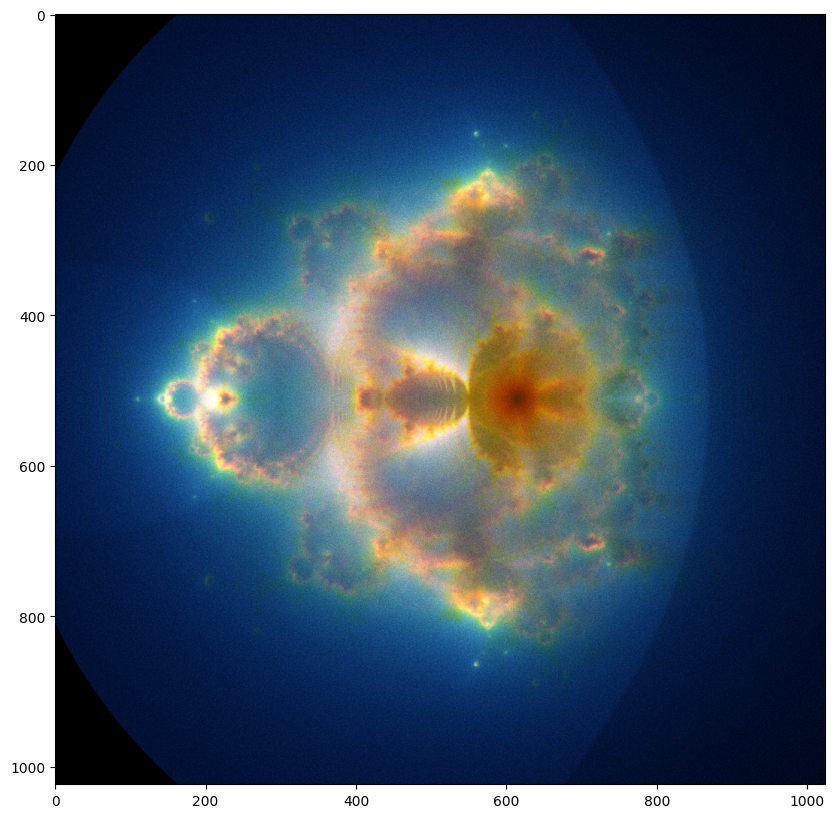

In [5]:
# plot the result
plt.figure(figsize=(10,10))
plt.imshow(resnp)
plt.show()

In [6]:
#import cv2 as cv
#import os
#
##use opencv to write is as video too
#video_path = 'H:/TestVideos/buddhabrot.mp4'
#fourcc = cv.VideoWriter_fourcc(*'H264')
#video = cv.VideoWriter(video_path, fourcc, 30, (S, S))
#
#frame_count = 200
#dtime = 0.1
#
#for i in range(frame_count):
#    time_var = tf.tensor(np.array([i * dtime], np.float32))
#    frame = np.zeros([S, S, 3], np.float32)
#    frame_tf = tf.tensor(frame)
#    frame_id = tf.tensor(np.array([0], np.int32))
#    
#    for j in range(30):
#        frame_tf, frame_id = mand(frame_tf, frame_id, time_var)
#
#    resnp = frame_tf.numpy
#    resnp = (resnp * 255).astype(np.uint8)
#    resnp = cv.cvtColor(resnp, cv.COLOR_RGB2BGR)
#    video.write(resnp)
#
#video.release()
